# Voting Classifier

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

In [2]:
wine = pd.read_csv('data\Data\white_wine.csv')
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


In [3]:
wine['alcohol'].fillna(wine['alcohol'].mean(), inplace=True)

In [4]:
wine['label'] = np.where(wine['quality']>6,1,0)
X = wine[['alcohol', 'density']]
y = wine['label']

# Data Splitting

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2020)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((416, 2), (104, 2), (416,), (104,))

In [6]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier(n_neighbors=3)

In [7]:
for clfs, clf_name in zip([lr, dt, knn], ['LogisticRegression', 'DecisionTree', 'KNN']):
    clfs.fit(X_train, y_train)
    y_pred = clfs.predict(X_test)
    print(f'{clf_name}: \n {classification_report(y_test, y_pred)}')

LogisticRegression: 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92        84
           1       0.75      0.45      0.56        20

    accuracy                           0.87       104
   macro avg       0.82      0.71      0.74       104
weighted avg       0.86      0.87      0.85       104

DecisionTree: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.90      0.95        20

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104

KNN: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        84
           1       0.75      0.75      0.75        20

    accuracy                           0.90       104
   macro avg       0.85      0.85      0.85       104
weighted avg       0.90      

In [8]:
vc = VotingClassifier([
    ('clf1', lr),
    ('clf2', dt),
    ('clf3', knn)
], voting='soft')

In [9]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('clf1',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('clf2',
                              DecisionTreeClassifier(ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gi...
                                        

In [10]:
y_pred_vc = vc.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred_vc))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        84
           1       1.00      0.80      0.89        20

    accuracy                           0.96       104
   macro avg       0.98      0.90      0.93       104
weighted avg       0.96      0.96      0.96       104




## Modeling Improvement

In [12]:
# Transformer
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
standard = StandardScaler()

pipeline_lr = Pipeline([
    ('preprocess', poly),
    ('clf', lr)
])

df = DecisionTreeClassifier(max_depth=5)

pipeline_knn = Pipeline([
    ('scaler', standard),
    ('clf', knn)
])

In [16]:
for clfs, clf_name in zip([pipeline_lr,dt,pipeline_knn],['Logistic Regression','Decision Tree','KNN']):
  clfs.fit(X_train, y_train)
  y_pred = clfs.predict(X_test)
  print(clf_name+":")
  print(classification_report(y_test,y_pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.90      0.95        20

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104

Decision Tree:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        84
           1       1.00      0.90      0.95        20

    accuracy                           0.98       104
   macro avg       0.99      0.95      0.97       104
weighted avg       0.98      0.98      0.98       104

KNN:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        84
           1       0.95      0.95      0.95        20

    accuracy                           0.98       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.98      0.98

In [18]:
vc_opt = VotingClassifier([('clf1', pipeline_lr), ('clf2', dt), ('clf3', pipeline_knn)], voting='soft')

In [19]:
vc_opt.fit(X_train, y_train)

VotingClassifier(estimators=[('clf1',
                              Pipeline(memory=None,
                                       steps=[('preprocess',
                                               PolynomialFeatures(degree=3,
                                                                  include_bias=False,
                                                                  interaction_only=False,
                                                                  order='C')),
                                              ('clf',
                                               LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_scaling=1,
                                                       

In [23]:
print(classification_report(y_test, y_pred_vc))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        84
           1       1.00      0.80      0.89        20

    accuracy                           0.96       104
   macro avg       0.98      0.90      0.93       104
weighted avg       0.96      0.96      0.96       104



In [22]:
y_pred_opt = vc_opt.predict(X_test)
print(classification_report(y_test, y_pred_opt))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99        84
           1       0.95      0.95      0.95        20

    accuracy                           0.98       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.98      0.98      0.98       104



# Random Forest

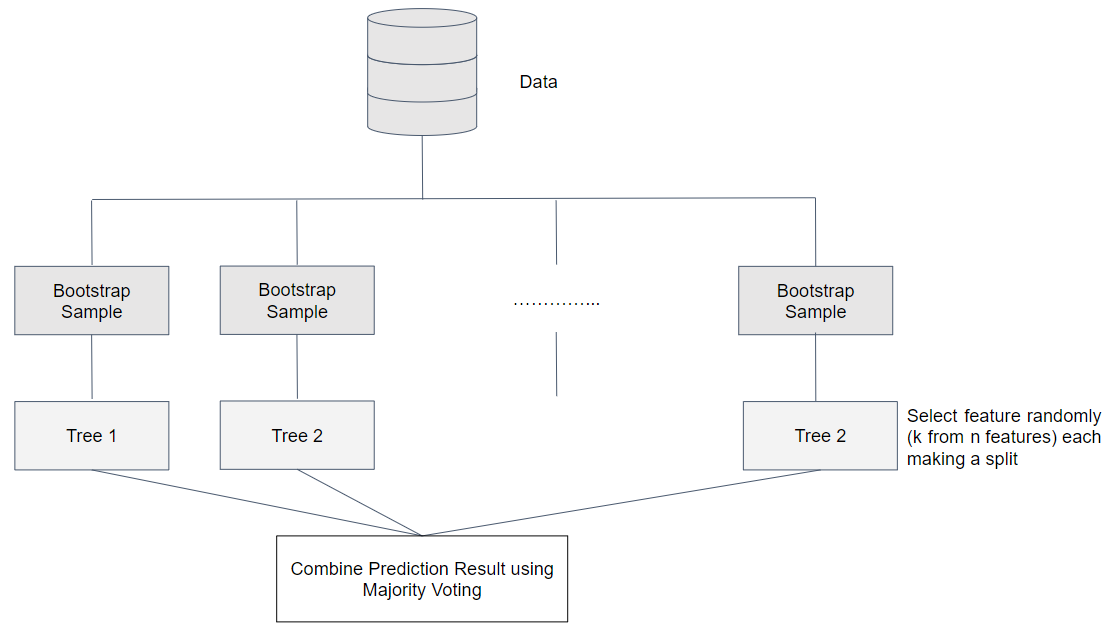

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report


### Data

In [25]:
bankloan = pd.read_csv('data/Data/bankloan.csv')
bankloan.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1
1,27,1,10,6,31,17.3,1.362202,4.000798,0
2,40,1,15,14,55,5.5,0.856075,2.168925,0
3,41,1,15,14,120,2.9,2.658720,0.821280,0
4,24,2,2,0,28,17.3,1.787436,3.056564,1


In [26]:
fitur = 'age employ debtinc creddebt othdebt'.split()
target = 'default'
X = bankloan[fitur]
y = bankloan[target]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2020)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((560, 5), (140, 5), (560,), (140,))

### Modelling

In [33]:
rfc = RandomForestClassifier(n_estimators=20, max_depth=3, oob_score=True, )
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
y_pred = rfc.predict(X_test)

In [35]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       167
           1       0.88      0.73      0.80        41

    accuracy                           0.93       208
   macro avg       0.91      0.85      0.88       208
weighted avg       0.93      0.93      0.93       208



In [37]:
len(rfc.estimators_)

20

In [38]:
rfc.oob_score_

0.9551282051282052

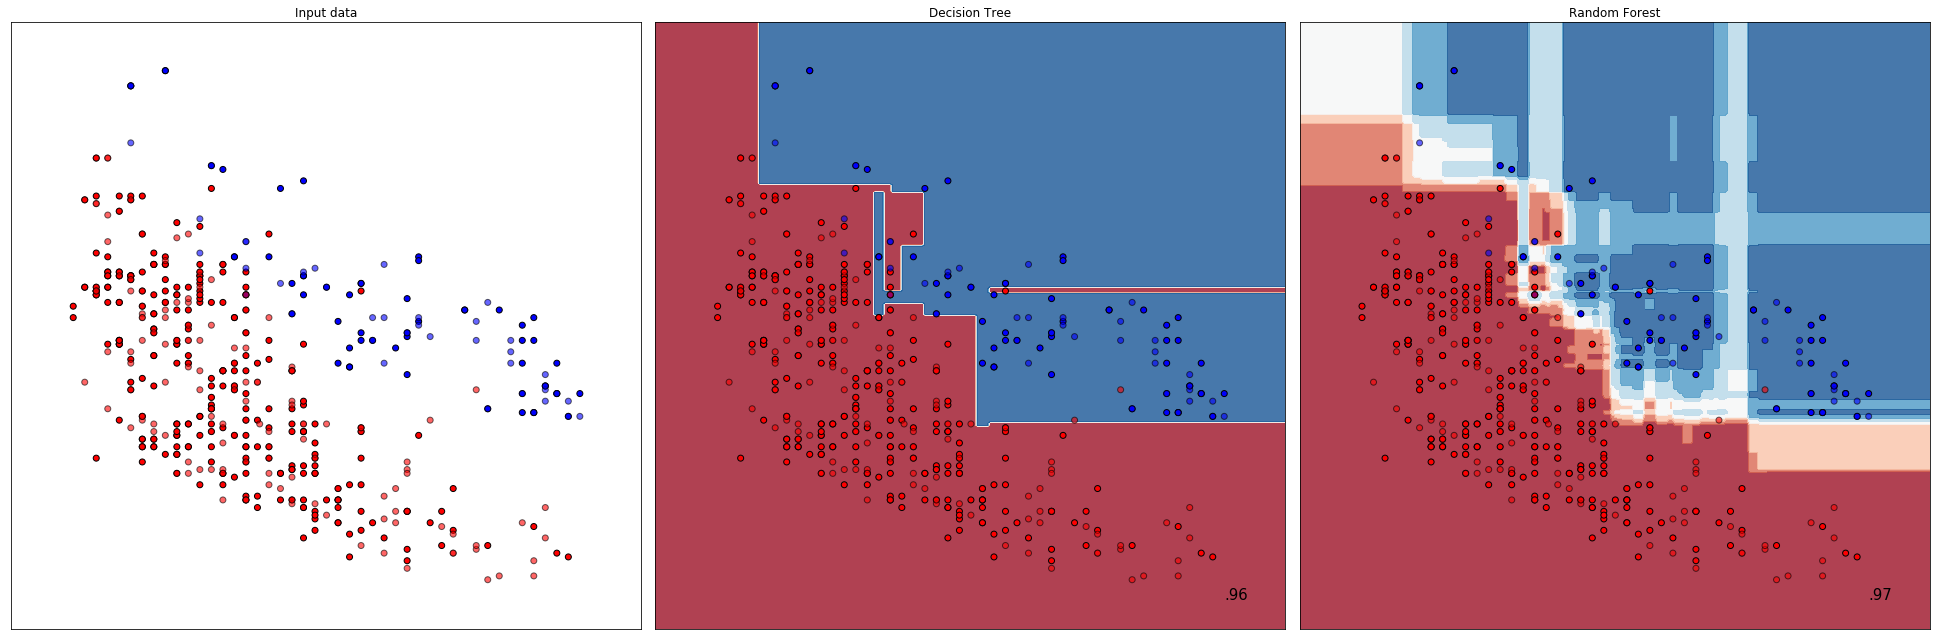

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
 
h = .02  # step size in the mesh
 
names = ["Decision Tree", "Random Forest"]
 
classifiers = [
    DecisionTreeClassifier(), # you can add more model
    RandomForestClassifier(n_estimators=20)]
 
X = wine[['alcohol','density']]
y = wine['label']
linearly_separable = (X, y)
 
datasets = [
            linearly_separable # you can add more dataset
            ]
 
figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)
 
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
 
    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1
 
    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
 
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
 
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
 
        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # Plot the testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)
 
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
 
plt.tight_layout()
plt.show()

### Bagging Classifier

In [39]:
from sklearn.ensemble import BaggingClassifier

In [40]:
logit = LogisticRegression()

In [41]:
bag_logit = BaggingClassifier(base_estimator=logit, n_estimators=10, oob_score=True, n_jobs=-1)
bag_logit.fit(X_train, y_train)

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\sklearn\ensemble\_bagging.py:633: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\sklearn\ensemble\_bagging.py:638: RuntimeWarning: invalid value encountered in true_divide
  predictions.sum(axis=1)[:, np.newaxis])


BaggingClassifier(base_estimator=LogisticRegression(C=1.0, class_weight=None,
                                                    dual=False,
                                                    fit_intercept=True,
                                                    intercept_scaling=1,
                                                    l1_ratio=None, max_iter=100,
                                                    multi_class='auto',
                                                    n_jobs=None, penalty='l2',
                                                    random_state=None,
                                                    solver='lbfgs', tol=0.0001,
                                                    verbose=0,
                                                    warm_start=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=1.0, n_estimators=10, n_jobs=-1, oob_score=True,
                  random_state=None, ve

In [43]:
print(classification_report(y_test, bag_logit.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       167
           1       0.92      0.85      0.89        41

    accuracy                           0.96       208
   macro avg       0.94      0.92      0.93       208
weighted avg       0.96      0.96      0.96       208



# Boosting
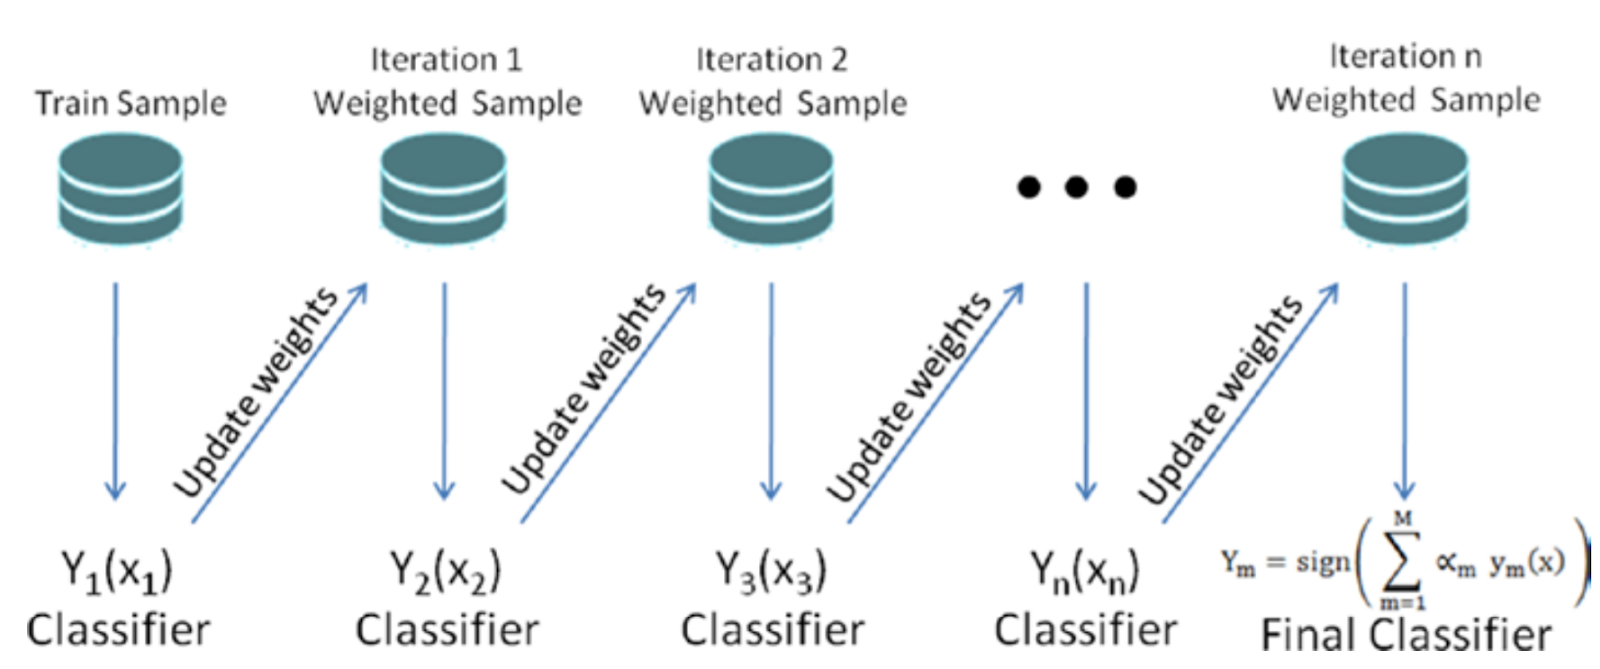

> ## Table Of Contents
1. Data
1. EDA
1. Missing value Exploration
1. Preprocessing
1. Data Splitting
1. Data Transformation
1. Model fitting and evaluation
1. Model properties

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [45]:
adult = pd.read_csv('data/Data/adult.csv')
adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [46]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [47]:
adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [48]:
adult.replace('?', np.nan, inplace=True)

In [49]:
adult.isnull().sum() / len(adult) * 100

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education.num     0.000000
marital.status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital.gain      0.000000
capital.loss      0.000000
hours.per.week    0.000000
native.country    1.790486
income            0.000000
dtype: float64

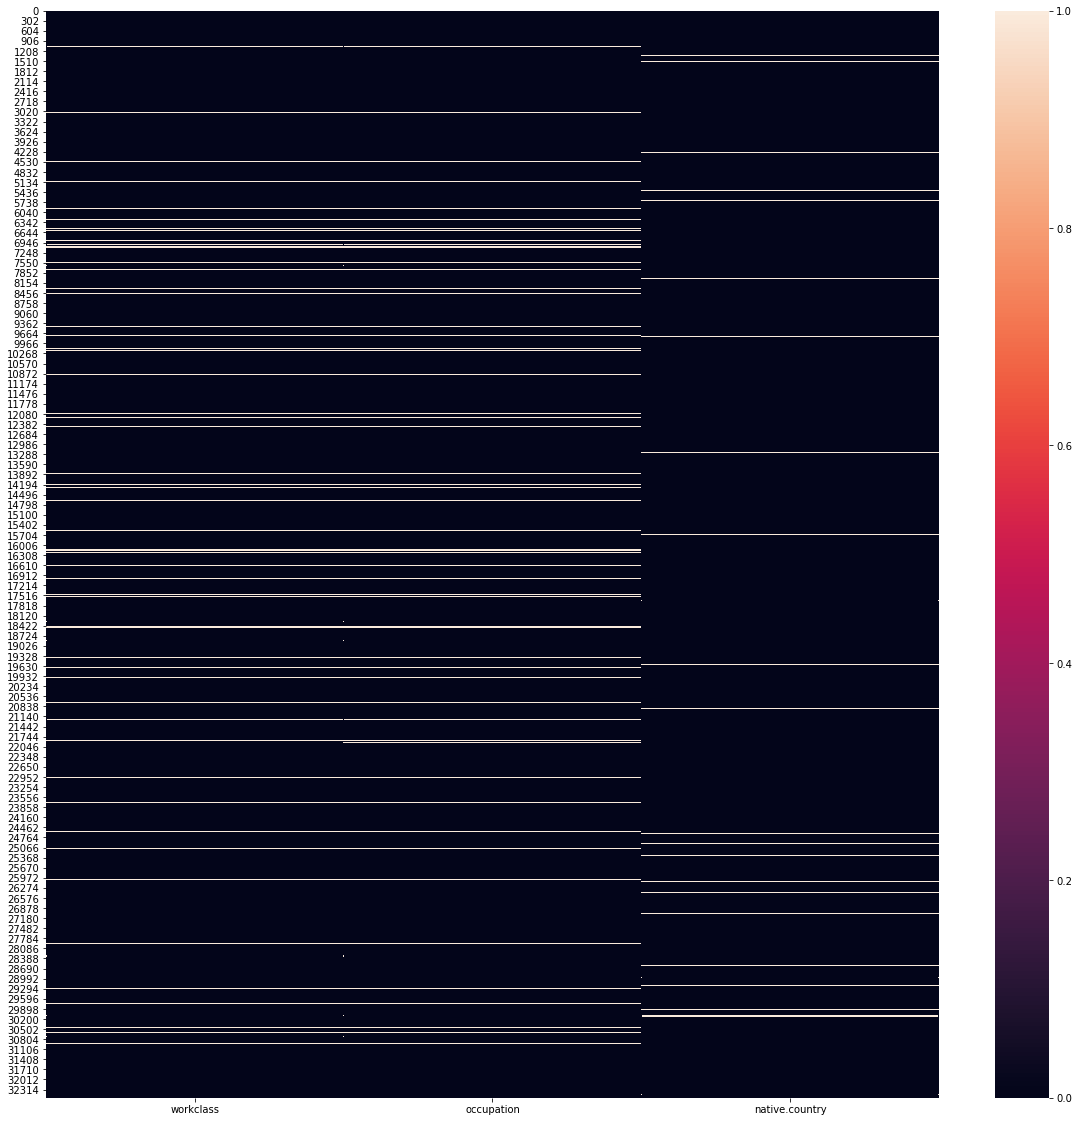

In [51]:
plt.figure(figsize=(20,20))
sns.heatmap(adult[['workclass', 'occupation', 'native.country']].isnull());

The Missing Variable:
1. workclass
1. occupation
1. native.country

>## Preprocessing

In [52]:
adult.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [54]:
adult.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [53]:
adult.describe(include=object)

,workclass,education,marital.status,occupation,relationship,race,sex,native.country,income
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


preprocess scheme:
1. one hot encoding : relationship, race, sex
1. binary encoding : workclass, marital status, occupation, native country  
1. ordinal encoding : education (already encoded)
1. no treatment : size

out:
1. fnlwgt

In [56]:
binary_encoder = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='NS')),
    ('binary', ce.BinaryEncoder())
])

transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['relationship', 'race', 'sex']),
    ('binary', binary_encoder, ['workclass', 'marital.status', 'occupation', 'native.country'])
], remainder='passthrough')

dtc_pipe = Pipeline([
    ('transformer', transformer),
    ('clf', DecisionTreeClassifier(max_depth=3))
])

>## Data Splitting

In [67]:
X = adult.drop(columns=['fnlwgt', 'income', 'education'])
y = np.where(adult['income'] == '>50K', 1, 0)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2020)
X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape

((26048, 12), (6513, 12), (26048,), (6513,))

In [70]:
dtc_pipe.fit(X_train_val, y_train_val)

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(memory=None,
      

In [69]:
y_pred = dtc_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4945
           1       0.80      0.65      0.72      1568

    accuracy                           0.88      6513
   macro avg       0.85      0.80      0.82      6513
weighted avg       0.87      0.88      0.87      6513



# Adaptive Boosting

In [71]:
tree = DecisionTreeClassifier(max_depth=3)
abc = AdaBoostClassifier(tree, n_estimators=200, learning_rate=0.1, random_state=10)

abc_pipe = Pipeline([
    ('transformer', transformer),
    ('clf', abc)
])

In [72]:
abc_pipe.fit(X_train_val, y_train_val)

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(memory=None,
      

In [73]:
y_pred_abc = abc_pipe.predict(X_test)
print(classification_report(y_test, y_pred_abc))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4945
           1       0.80      0.65      0.72      1568

    accuracy                           0.88      6513
   macro avg       0.85      0.80      0.82      6513
weighted avg       0.87      0.88      0.87      6513



In [74]:
abc_pipe[1].feature_importances_

array([0.00713462, 0.00869812, 0.01583507, 0.02170331, 0.03023728,
       0.01372   , 0.0124055 , 0.00260944, 0.00601149, 0.01622898,
       0.        , 0.00056557, 0.0245115 , 0.01520246, 0.02795073,
       0.        , 0.01030829, 0.03548378, 0.02646959, 0.        ,
       0.03674383, 0.01982192, 0.01602423, 0.05299548, 0.        ,
       0.00298442, 0.00170339, 0.00660772, 0.00781059, 0.00571521,
       0.00149541, 0.14608609, 0.11458492, 0.09476015, 0.07982703,
       0.13776387])

## Gradient Boosting Classifer

In [75]:
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=2020)

gbc_pipe = Pipeline([
    ('transformer', transformer),
    ('clf', gbc)
])

gbc_pipe.fit(X_train_val, y_train_val)

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(memory=None,
      

In [76]:
gbc_pred = gbc_pipe.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4945
           1       0.80      0.65      0.72      1568

    accuracy                           0.88      6513
   macro avg       0.85      0.80      0.82      6513
weighted avg       0.87      0.88      0.87      6513



## Extreme Gradient Boosting Classifier

In [78]:
xgbc = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=10)

xgbc_pipe = Pipeline([
    ('transformer', transformer),
    ('clf', xgbc)
])

xgbc_pipe.fit(X_train_val, y_train_val)

C:\ProgramData\miniconda3\envs\ml_dl\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('transformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehot',
                                                  OneHotEncoder(categories='auto',
                                                                drop='first',
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                sparse=True),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary',
                                                  Pipeline(memory=None,
      

In [80]:
xgbc_pred = xgbc_pipe.predict(X_test)
print(classification_report(y_test, xgbc_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4945
           1       0.81      0.63      0.71      1568

    accuracy                           0.88      6513
   macro avg       0.85      0.79      0.82      6513
weighted avg       0.87      0.88      0.87      6513



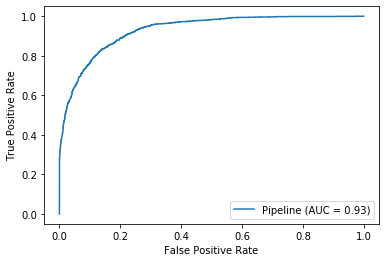

In [82]:
plot_roc_curve(abc_pipe, X_test, y_test);

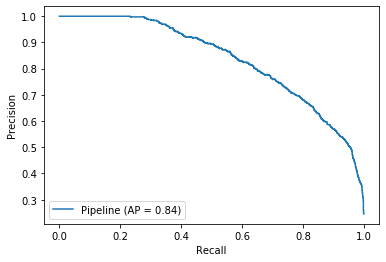

In [84]:
plot_precision_recall_curve(abc_pipe, X_test, y_test);

## Hyperparameter TUning for AdaBoostClassifier

In [86]:
model_tree = DecisionTreeClassifier(max_depth=3)

model_ada = AdaBoostClassifier(
    model_tree,
    n_estimators=200,
    learning_rate=0.1,
    random_state=10
)

ada_pipe = Pipeline([
    ('transform', transformer),
    ('clf', model_ada)
])

hyperparam_space = [
    {'clf__learning_rate': [0.1], 'clf__n_estimators': [200], 'clf__base_estimator__max_depth': [3, 4, 5]},
    {'clf__learning_rate': [0.05], 'clf__n_estimators': [400], 'clf__base_estimator__max_depth': [3, 4, 5]},
    {'clf__learning_rate': [0.01], 'clf__n_estimators': [2000], 'clf__base_estimator__max_depth': [3, 4, 5]},
    {'clf__learning_rate': [0.005], 'clf__n_estimators': [4000], 'clf__base_estimator__max_depth': [3, 4, 5]},
]

skfold = StratifiedKFold(n_splits=5)

gridsearch_ada = GridSearchCV(
    ada_pipe,
    param_grid = hyperparam_space,
    cv = skfold,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)

In [ ]:
gridsearch_ada.fit(X_train_val, y_train_val)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
